<a href="https://colab.research.google.com/github/no1rabbit/Cloud_chasing/blob/main/rainfall_2_week_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Now import TensorFlow and it will use CPU
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

from math import cos
from tqdm import tqdm
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# view all the entire dataset not truncated
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths to your data
gps_file = '/content/drive/MyDrive/Cloud data/Serengeti_HMM.csv'

# Load GPS data
gps_data = pd.read_csv(gps_file)
gps_data = gps_data[gps_data['case_'] == True]
gps_data['sp_m'] = gps_data['species'] + '_' + gps_data['migrant'].astype(str)
gps_data = gps_data[gps_data['sp_m'] == 'WB_migrant']
gps_data['date'] = pd.to_datetime(gps_data['date'])
gps_data['date'] = gps_data['date'].dt.date


In [ ]:
gps_data.head()

,ID,x1_,x2_,y1_,y2_,sl_,ta_,species,migrant,date,x,y,sex,dailystate,year,months,mon2,season,burst_,t1_,t2_,dt_,case_,step_id_,cos_ta_,log_sl_,sl_dist_shape,sl_dist_scale,ta_dist_kappa,ta_dist_mu,sp_m
0,SW100,680764.8743,674933.7549,9724120.192,9728178.122,7104.136073,-0.431814,WB,migrant,2021-12-13,-2.497654,34.626559,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-13T07:30:00Z,2021-12-14T07:30:00Z,86400,True,3,0.908208,8.868432,0.810685,5075.168409,0.777039,0,WB_migrant
11,SW100,674933.7549,675019.5210,9728178.122,9727439.122,743.960230,2.294312,WB,migrant,2021-12-14,-2.461019,34.574084,F,encamped,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-14T07:30:00Z,2021-12-15T07:30:00Z,86400,True,4,-0.662023,6.611988,0.810685,5075.168409,0.777039,0,WB_migrant
22,SW100,675019.5210,673586.9019,9727439.122,9726742.822,1592.868851,-1.233925,WB,migrant,2021-12-15,-2.467701,34.574863,F,encamped,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-15T07:30:00Z,2021-12-16T07:30:00Z,86400,True,5,0.330536,7.373292,0.810685,5075.168409,0.777039,0,WB_migrant
33,SW100,673586.9019,669799.8705,9726742.822,9723233.359,5163.132516,0.294964,WB,migrant,2021-12-16,-2.474014,34.561989,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-16T07:30:00Z,2021-12-17T07:30:00Z,86400,True,6,0.956813,8.549299,0.810685,5075.168409,0.777039,0,WB_migrant
44,SW100,669799.8705,666982.3274,9723233.359,9716497.189,7301.680313,0.427264,WB,migrant,2021-12-17,-2.505793,34.527973,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-17T07:30:00Z,2021-12-18T07:30:00Z,86400,True,7,0.910103,8.895860,0.810685,5075.168409,0.777039,0,WB_migrant


In [ ]:
# change year to start in feb instead of jan
def get_new_year(date):
    year = date.year
    month = date.month
    if month == 1:
        year -= 1
    return pd.Timestamp(year, month, date.day)

gps_data['date'] = gps_data['date'].apply(get_new_year)
gps_data['date'] = gps_data['date'].dt.date

# split into seasons
def get_season(date):
    if date.month in [11, 12, 1]:
        return 'dry to wet'
    elif date.month in [2, 3, 4]:
        return 'wet'
    elif date.month in [5, 6, 7]:
        return 'wet to dry'
    else:
        return 'dry'

gps_data['season'] = gps_data['date'].apply(get_season)

gps_data = gps_data.sort_values(by=['ID','date'])

In [ ]:
# subset dataset to dry to wet season
#gps_data = gps_data[gps_data['season'] == 'dry to wet']


In [ ]:
gps_data.tail()
#max and min dates
print(gps_data['date'].min())
print(gps_data['date'].max())

2014-01-03
2022-05-30


In [ ]:
##

ds = xr.open_dataset('/content/drive/MyDrive/Cloud data/Serengeti_chirps_wide.nc')
##

In [ ]:
# Define parameters for the image
image_size = 32
step = 7
lag = 7

# Create an empty array to store image-GPS pairs
xdata = np.zeros((len(gps_data),image_size,image_size,lag))
ydata = np.zeros((len(gps_data),2))
years = np.zeros(len(gps_data))
seasons = np.zeros(len(gps_data), dtype=object)
#dates = np.empty(len(gps_data), dtype='datetime64[ns]')

i=0
for uid in tqdm(gps_data['ID'].unique()):
    current_data = gps_data[gps_data['ID'] == uid]
    # iterate through every other row
    for index, row in current_data.iterrows():

        # if index % step != 0:
        #     continue

        # Extract GPS coordinates and time from the DataFrame
        center_x = row['x1_']
        center_y = row['y1_']
        center_date = row['date']
        # find the row that is step days later
        next_date = center_date + pd.Timedelta(days=step)
        next_data = current_data[current_data['date'] == next_date]
        if len(next_data) == 0:
            continue
        next_x = next_data['x1_'].values[0]
        next_y = next_data['y1_'].values[0]
        ydata[i] = [next_x - center_x, next_y - center_y]

        # Convert latitude and longitude to indices in the xarray dataset
        x_index = np.abs(ds.x - center_x).argmin().values
        y_index = np.abs(ds.y - center_y).argmin().values

        # Find the index corresponding to the center_time in the time dimension
        time_index = np.abs(ds.time - np.datetime64(center_date)).argmin().values
        if time_index - lag < 0:
            continue

        # Extract a subset of the dataset centered around the specified location for 1 week starting at the current time
        subset = ds.isel(x=slice(x_index - image_size//2, x_index + image_size//2),
                            y=slice(y_index - image_size//2, y_index + image_size//2),
                            time=slice(time_index - lag + 1, time_index+1))

        # Extract the 2D array of the variable you want to visualize
        data_array = subset.rainfall.values

        # Check for NaN and infinite values
        if np.isnan(data_array).any() or np.isinf(data_array).any():
            print(f"Warning: NaN or infinite values found in data_array for ID {uid}, index {index}, time_index {time_index}")
            print(f"NaN values: {np.sum(np.isnan(data_array))}")
            print(f"Infinite values: {np.sum(np.isinf(data_array))}")

        # Handle invalid values by replacing NaN and infinite values with 0
        # normalized_data = np.nan_to_num((data_array - np.min(data_array)) / (np.max(data_array) - np.min(data_array)))
        data_array = np.nan_to_num(data_array)

        # data_array = np.mean(data_array,axis=0)
        data_array = np.transpose(data_array,[1,2,0])

        # Store data_array in xdata
        xdata[i] = data_array
        xdata[i] = data_array #np.reshape(data_array, (image_size, image_size, 1))
        years[i] = center_date.year
        seasons[i] = row['season']
        #dates[i] = center_date
        i += 1



100%|██████████| 59/59 [02:30<00:00,  2.55s/it]


In [ ]:
##
print(i)
xdata = xdata[:i]
ydata = ydata[:i]
years = years[:i]
seasons = seasons[:i]
xdata = xdata.astype('float32')
xdata = xdata / np.percentile(xdata,95)
ydata = ydata.astype('float32')
ydata = ydata / np.linalg.norm(ydata,axis=1,keepdims=True)

# Convert the seasons to one-hot encoding
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
seasons_onehot = encoder.fit_transform(seasons.reshape(-1,1))
# Reshape seasons_onehot to have the same number of dimensions as xdata
seasons_onehot_reshaped = seasons_onehot.reshape(-1, 1, 1, seasons_onehot.shape[1])
# Repeat seasons_onehot_reshaped along the second and third dimensions
seasons_onehot_repeated = np.repeat(seasons_onehot_reshaped, image_size, axis=1)
seasons_onehot_repeated = np.repeat(seasons_onehot_repeated, image_size, axis=2)

# Concatenate the one-hot encoded seasons with your feature matrix
xdata = np.concatenate([xdata, seasons_onehot_repeated], axis=3)

##

28573


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


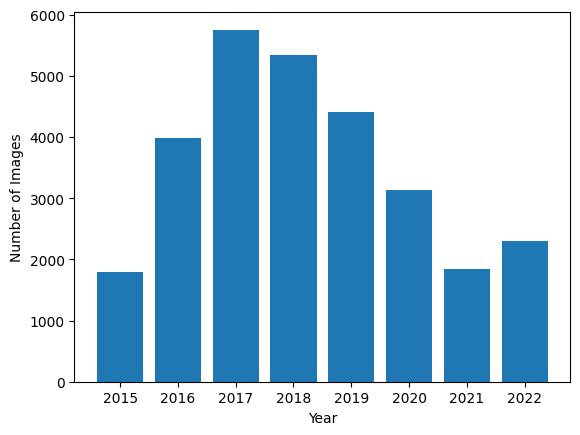

In [ ]:
# count the number of images for each year
unique_years, counts = np.unique(years, return_counts=True)
plt.bar(unique_years, counts)
plt.xlabel('Year')
plt.ylabel('Number of Images')
plt.show()
##


# Step 2: Preprocess Images and Combine with GPS Data

In [ ]:
# Split the data into training and testing sets
# from sklearn.model_selection import train_test_split

# xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.2, random_state=42)

# use 2018 for testing and the rest for training
xtrain = xdata[years != 2018]
ytrain = ydata[years != 2018]
xtest = xdata[years == 2018]
ytest = ydata[years == 2018]


# Step 3: Model-Specific Preprocessing

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define your model
#image_input = layers.Input(shape=(image_size, image_size, lag), name='image_input')
image_input = layers.Input(shape=(image_size, image_size, lag+4), name='image_input')

# Image processing branch
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)


# Output layer for heading prediction
output = layers.Dense(2, activation='linear')(x)

# keras layer for normalizing the output vector to have unit norm
output = layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1))(output)

# Define the model with multiple inputs
model = models.Model(inputs=image_input, outputs=output)

opt = Adam(learning_rate=1e-2)
model.compile(optimizer=opt,loss=tf.keras.losses.CosineSimilarity(axis=-1))

# Display the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 32, 32, 11)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 8)         800       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 8)           584   

# Step 4: Model Training

In [ ]:
# fit with early stopping on the validation loss
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# Train the model with learning rate decay
model.fit(xtrain, ytrain, epochs=100, validation_data=(xtest, ytest), callbacks=[es], batch_size=128)



Epoch 1/100
182/182 [==============================] - 15s 20ms/step - loss: -0.1896 - val_loss: -0.2201
Epoch 2/100
182/182 [==============================] - 2s 9ms/step - loss: -0.2488 - val_loss: -0.2453
Epoch 3/100
182/182 [==============================] - 2s 8ms/step - loss: -0.2564 - val_loss: -0.2696
Epoch 4/100
182/182 [==============================] - 2s 9ms/step - loss: -0.2596 - val_loss: -0.2676
Epoch 5/100
182/182 [==============================] - 2s 9ms/step - loss: -0.2689 - val_loss: -0.2603
Epoch 6/100
182/182 [==============================] - 2s 9ms/step - loss: -0.2624 - val_loss: -0.2772
Epoch 7/100
182/182 [==============================] - 2s 10ms/step - loss: -0.2789 - val_loss: -0.2659
Epoch 8/100
182/182 [==============================] - 2s 11ms/step - loss: -0.2841 - val_loss: -0.2766
Epoch 9/100
182/182 [==============================] - 2s 11ms/step - loss: -0.2819 - val_loss: -0.2673
Epoch 10/100
182/182 [==============================] - 2s 11ms/step

# Step 5: Model Evaluation

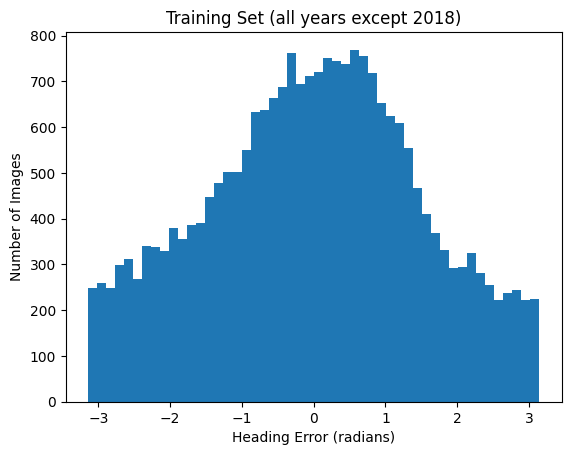

In [ ]:
# predict on the train set in batches of 512

for i in range(0,len(xtrain),512):
    preds = model.predict(xtrain[i:i+512],verbose=0)
    if i == 0:
        all_preds = preds
    else:
        all_preds = np.concatenate((all_preds,preds),axis=0)


a = np.arctan2(ytrain[:,1],ytrain[:,0]) - np.arctan2(all_preds[:,1],all_preds[:,0])

a[a > np.pi] = a[a > np.pi] - 2*np.pi
a[a < -np.pi] = a[a < -np.pi] + 2*np.pi

plt.hist(a,bins=50)
plt.title('Training Set (all years except 2018)')
plt.xlabel('Heading Error (radians)')
plt.ylabel('Number of Images')
plt.show()



167/167 [==============================] - 1s 4ms/step


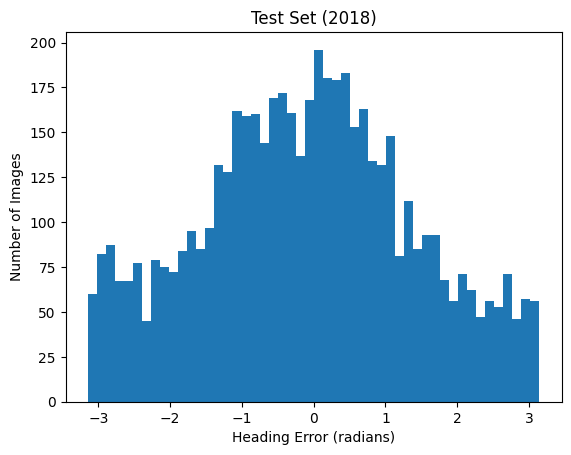

In [ ]:
preds = model.predict(xtest)

# plot a histogram of the difference between true and predicted angles
a = np.arctan2(ytest[:,1],ytest[:,0]) - np.arctan2(preds[:,1],preds[:,0])

a[a > np.pi] = a[a > np.pi] - 2*np.pi
a[a < -np.pi] = a[a < -np.pi] + 2*np.pi

plt.hist(a,bins=50)
plt.title('Test Set (2018)')
plt.xlabel('Heading Error (radians)')
plt.ylabel('Number of Images')
plt.show()
##

To visualize the average rainfall map aligned with the predicted heading of the wildebeest, you would first need to rotate each rainfall map so that the direction of the wildebeest's movement is aligned with a fixed direction (e.g., upwards). Then, you can average all the rotated maps. Here's a step-by-step guide:

1. **Define a function to rotate an image**:



In [ ]:
from scipy.ndimage import rotate

def rotate_image(image, angle):
    return rotate(image, angle, reshape=False)



2. **Rotate each rainfall map**:

Assuming `rainfall_maps` is a list of your rainfall maps and `headings` is a list of the predicted headings of the wildebeest:



In [ ]:
rotated_maps = [rotate_image(map, -heading) for map, heading in zip(xdata, a)]



Note that we rotate by `-heading` because a positive rotation is counter-clockwise, but a positive heading is usually clockwise.

3. **Average the rotated maps**:



In [ ]:
average_map = np.mean(rotated_maps, axis=0)
average_map_over_time = np.mean(average_map, axis=2)



4. **Visualize the average map**:



In [ ]:
average_heading_x = np.cos(a).mean()
average_heading_y = np.sin(a).mean()

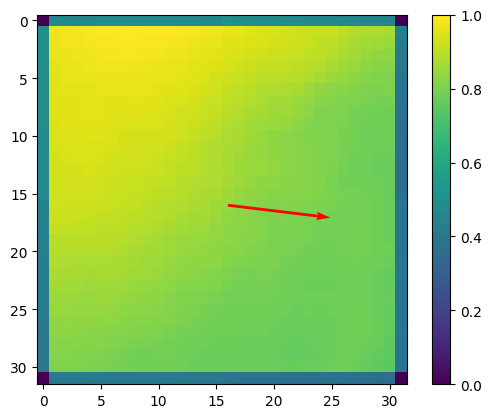

In [ ]:
plt.imshow(average_map_over_time, cmap='viridis')
plt.quiver(average_map_over_time.shape[1] / 2, average_map_over_time.shape[0] / 2, average_heading_x, average_heading_y, color='r', scale=1)
plt.colorbar()
plt.show()

In [ ]:
gradient_y, gradient_x = np.gradient(average_map_over_time)
average_heading_x = np.cos(a).mean()
average_heading_y = np.sin(a).mean()

dot_product = gradient_x * average_heading_x + gradient_y * average_heading_y

0.03970041068468198


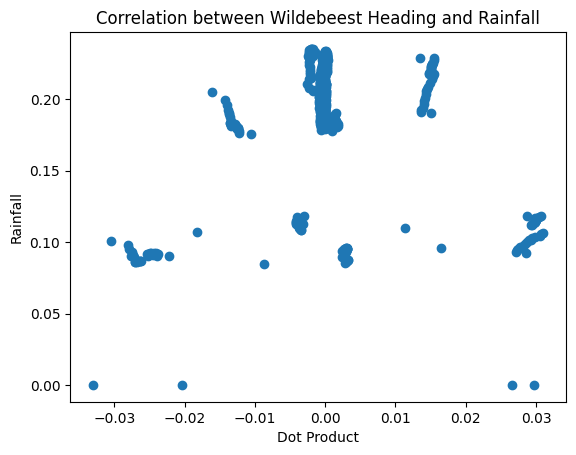

In [ ]:
correlation = np.corrcoef(dot_product.flatten(), average_map_over_time.flatten())[0, 1]
print(correlation)

plt.scatter(dot_product.flatten(), average_map_over_time.flatten())
plt.xlabel('Dot Product')
plt.ylabel('Rainfall')
plt.title('Correlation between Wildebeest Heading and Rainfall')
plt.show()

In [ ]:
seasons

['dry to wet', 'wet', 'wet to dry', 'dry']

In [ ]:
# Assuming `dot_product` is the dot product between the wildebeest's heading and the gradient,
# `average_map_over_time` is the average rainfall map,
# and `seasons` is a list of the season for each data point

# Create a dictionary to map seasons to colors
season_colors = {'dry': 'blue', 'dry to wet': 'green', 'wet': 'red', 'wet to dry': 'orange'}

# Create a scatter plot for each season
for season in ['dry', 'dry to wet', 'wet', 'wet to dry']:
    plt.scatter(dot_product[seasons == season].flatten(),
                average_map_over_time[seasons == season].flatten(),
                color=season_colors[season],
                label=season)

plt.xlabel('Dot Product')
plt.ylabel('Rainfall')
plt.title('Correlation between Wildebeest Heading and Rainfall by Season')
plt.legend()
plt.show()

IndexError: ignored

In [ ]:
seasons = ['dry to wet', 'wet', 'wet to dry', 'dry']

for season in seasons:
    # Filter the data for the current season
    season_indices = np.where(gps_data['season'] == season)
    dot_product_season = dot_product.flatten()[season_indices]
    average_map_season = average_map_over_time.flatten()[season_indices]

    # Calculate and print the correlation for the current season
    correlation = np.corrcoef(dot_product_season, average_map_season)[0, 1]
    print(f'{season} correlation: {correlation}')

    # Create a scatter plot for the current season
    plt.scatter(dot_product_season, average_map_season)
    plt.xlabel('Dot Product')
    plt.ylabel('Rainfall')
    plt.title(f'Correlation between Wildebeest Heading and Rainfall in {season}')
    plt.show()

IndexError: ignored

In [ ]:
print(len(gps_data))
print(len(dot_product.flatten()))
print(season_indices)

31920
1024
(array([    0,     1,     2, ..., 31805, 31806, 31807]),)


Animation of rainfall

<Figure size 640x480 with 0 Axes>

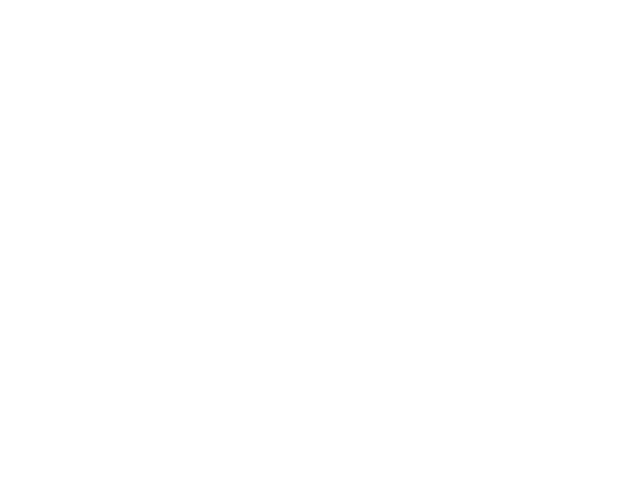

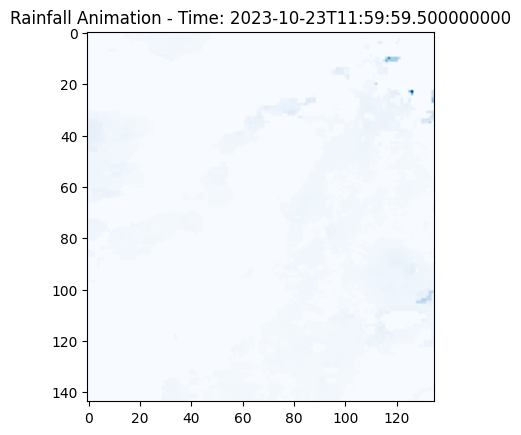

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define the function to update the plot for each frame of the animation
def update(frame):
    plt.clf()  # Clear the current figure
    plt.imshow(ds.rainfall[frame], cmap='Blues')  # Plot the rainfall data for the current frame
    plt.title(f'Rainfall Animation - Time: {ds.time[frame].values}')  # Set the title of the plot

# Create the animation
fig = plt.figure()
ani = animation.FuncAnimation(fig, update, frames=len(ds.time), interval=500)

# Display the animation
plt.show()
ani.save('animation.gif', writer='pillow')

from IPython.display import Image
Image(filename="animation.gif")

<Figure size 640x480 with 0 Axes>

KeyError: 1860

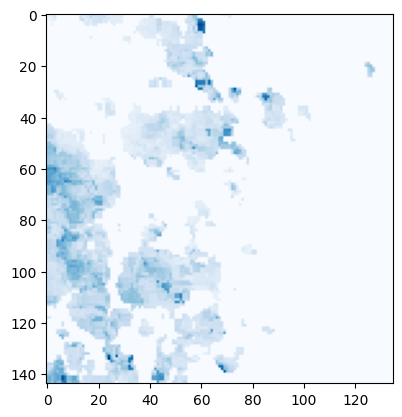

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Filter the GPS data for the individual SW47 and reset the index
gps_data_SW47 = gps_data[gps_data['ID'] == 'SW47'].reset_index(drop=True)

# Define the function to update the plot for each frame of the animation
def update(frame):
    plt.clf()  # Clear the current figure
    plt.imshow(ds.rainfall[frame], cmap='Blues')  # Plot the rainfall data for the current frame
    plt.scatter(gps_data_SW47['x1_'][frame], gps_data_SW47['y1_'][frame], color='red')  # Plot the GPS data for the current frame
    plt.title(f'Rainfall and GPS Animation for SW47 - Time: {ds.time[frame].values}')  # Set the title of the plot

# Create the animation
fig = plt.figure()
ani = animation.FuncAnimation(fig, update, frames=len(ds.time), interval=500)

# Display the animation
plt.show()

# Save the animation
ani.save('animationSW47.gif', writer='pillow')

# Display the saved animation
from IPython.display import Image
Image(filename="animationSW47.gif")